- recent update: 24.10.29
- update content:
    1. mid-price 생성
    2. significant or insignificant 예측 모델 생성
    3. significant 예측되는 경우에만 significant increase or decrease인지 예측
- target var: mid price return significant change (0 or 1)
- Model: XGBoost(significant or insignificant 예측) + LSTM(significant increase or decrease 예측)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
#from optuna.integration import XGBoostPruningCallback
#import optuna

In [3]:
# display max
#pd.set_option('display.max_rows', 90)
#pd.set_option('display.max_column', None)

In [4]:
df_origin = pd.read_csv('/content/drive/MyDrive/eunsung/data/df_processed_month3_1m5m_maxreturn.csv')

In [5]:
# 시간 타입으로 변경
df_origin['false.2'] = pd.to_datetime(df_origin['false.2'])

# 데이터프레임 리샘플링 - 'timestamp_column'을 타임스탬프 컬럼 이름으로 변경하세요
df_origin.set_index('false.2', inplace=True)  # 타임스탬프를 인덱스로 설정
df = df_origin.resample('5S').mean()  # 1초 단위로 묶어서 평균값 계산

# 결과 확인
df.head(20)
print(df.shape)

df.reset_index(inplace=True)

<ipython-input-5-a7240cd65826>:6: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df_origin.resample('5S').mean()  # 1초 단위로 묶어서 평균값 계산


(86400, 86)


In [6]:
df.columns

Index(['false.2', 'ask_price_1', 'ask_price_10', 'ask_price_11',
       'ask_price_12', 'ask_price_13', 'ask_price_14', 'ask_price_15',
       'ask_price_2', 'ask_price_3', 'ask_price_4', 'ask_price_5',
       'ask_price_6', 'ask_price_7', 'ask_price_8', 'ask_price_9',
       'ask_size_1', 'ask_size_10', 'ask_size_11', 'ask_size_12',
       'ask_size_13', 'ask_size_14', 'ask_size_15', 'ask_size_2', 'ask_size_3',
       'ask_size_4', 'ask_size_5', 'ask_size_6', 'ask_size_7', 'ask_size_8',
       'ask_size_9', 'bid_price_1', 'bid_price_10', 'bid_price_11',
       'bid_price_12', 'bid_price_13', 'bid_price_14', 'bid_price_15',
       'bid_price_2', 'bid_price_3', 'bid_price_4', 'bid_price_5',
       'bid_price_6', 'bid_price_7', 'bid_price_8', 'bid_price_9',
       'bid_size_1', 'bid_size_10', 'bid_size_11', 'bid_size_12',
       'bid_size_13', 'bid_size_14', 'bid_size_15', 'bid_size_2', 'bid_size_3',
       'bid_size_4', 'bid_size_5', 'bid_size_6', 'bid_size_7', 'bid_size_8',
       'bid

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   false.2                    86400 non-null  datetime64[ns, UTC]
 1   ask_price_1                86386 non-null  float64            
 2   ask_price_10               86386 non-null  float64            
 3   ask_price_11               86386 non-null  float64            
 4   ask_price_12               86386 non-null  float64            
 5   ask_price_13               86386 non-null  float64            
 6   ask_price_14               86386 non-null  float64            
 7   ask_price_15               86386 non-null  float64            
 8   ask_price_2                86386 non-null  float64            
 9   ask_price_3                86386 non-null  float64            
 10  ask_price_4                86386 non-null  float64            
 11  as

In [8]:
df.head()

,false.2,ask_price_1,ask_price_10,ask_price_11,ask_price_12,ask_price_13,ask_price_14,ask_price_15,ask_price_2,ask_price_3,...,slope4,slope5,slope6,slope7,cum_sum_of_depths,cum_sum_of_bid_ask_spread,1_min_return,5_min_return,1_min_return_atbest,5_min_return_atbest
0,2024-03-07 00:00:00+00:00,9.335421e+07,9.337988e+07,9.338415e+07,9.338906e+07,9.339275e+07,9.339500e+07,9.339648e+07,9.336115e+07,9.336396e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-03-07 00:00:05+00:00,9.326708e+07,9.337415e+07,9.337651e+07,9.337995e+07,9.338454e+07,9.338913e+07,9.339469e+07,9.332405e+07,9.333049e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-03-07 00:00:10+00:00,9.328897e+07,9.337226e+07,9.337456e+07,9.337664e+07,9.337892e+07,9.338310e+07,9.338756e+07,9.330805e+07,9.332415e+07,...,0.998741,0.998475,0.998371,0.998344,1.332348,757875.000000,NaN,NaN,0.000529,0.000529
3,2024-03-07 00:00:15+00:00,9.332995e+07,9.337244e+07,9.337463e+07,9.337678e+07,9.337898e+07,9.338334e+07,9.338880e+07,9.334134e+07,9.334488e+07,...,0.998727,0.998534,0.998435,0.998380,1.655011,785902.439024,NaN,NaN,0.000386,0.000386
4,2024-03-07 00:00:20+00:00,9.333690e+07,9.337003e+07,9.337182e+07,9.337372e+07,9.337603e+07,9.337826e+07,9.338321e+07,9.333933e+07,9.334221e+07,...,0.998647,0.998547,0.998439,0.998376,1.328522,875051.282051,NaN,NaN,0.000312,0.000312


In [9]:
df.shape

(86400, 87)

In [10]:
df.isna().sum()

,0
false.2,0
ask_price_1,14
ask_price_10,14
ask_price_11,14
ask_price_12,14
...,...
cum_sum_of_bid_ask_spread,28
1_min_return,86400
5_min_return,86400
1_min_return_atbest,28


In [11]:
# # 데이터 시간 형태로 변경
# df['false.2'] = pd.to_datetime(df['false.2'])
# print(df.groupby(df['false.2'].dt.day).size().reset_index(name='num_rows'))

# # 특정 요일의 값만 추출
# day_num = 7
# df = df[df['false.2'].dt.day == day_num]

In [12]:
# mid_price를 기반으로 한 수익률 컬럼 생성
df['mid_price_return'] = df['mid_price'].pct_change() * 100
df['mid_price_return']

<ipython-input-12-23107a4ec48d>:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['mid_price_return'] = df['mid_price'].pct_change() * 100


,mid_price_return
0,NaN
1,NaN
2,NaN
3,0.002957
4,-0.014406
...,...
86395,0.000000
86396,0.000000
86397,0.000000
86398,0.000000


In [13]:
# 필요한 데이터 분류 작업을 진행하기 위해 종속변수 기준 설정 및 분류 함수 정의

# 분류 함수 정의 (논문 기준)
def classify_return(value, threshold):
    if value > threshold:
        return 'Significant increase'
    elif value < -threshold:
        return 'Significant decrease'
    elif 0 <= value <= threshold:
        return 'Insignificant increase'
    elif -threshold <= value < 0:
        return 'Insignificant decrease'
    else:
        return 'Unknown'

# 종속변수 '1_min_return_atbest'와 '5_min_return_atbest'에 대해 분류 수행
df['mid_price_return_class'] = df['mid_price_return'].apply(classify_return, threshold=0.002) # threshold: 0.002

# 분류된 데이터 확인
df[['mid_price_return', 'mid_price_return_class']].head()


,mid_price_return,mid_price_return_class
0,NaN,Unknown
1,NaN,Unknown
2,NaN,Unknown
3,0.002957,Significant increase
4,-0.014406,Significant decrease


array([[<Axes: title={'center': 'mid_price_return'}>]], dtype=object)

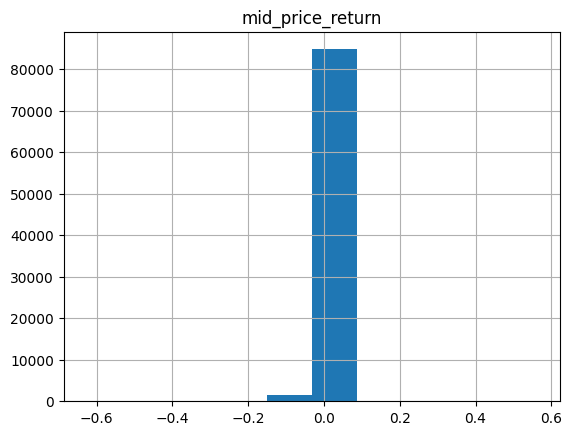

In [14]:
df[['mid_price_return', 'mid_price_return_class']].hist()

In [15]:
df[['mid_price_return', 'mid_price_return_class']].describe()

,mid_price_return
count,86397.000000
mean,0.000086
std,0.014884
min,-0.627327
25%,-0.002854
50%,0.000000
75%,0.002984
max,0.562330


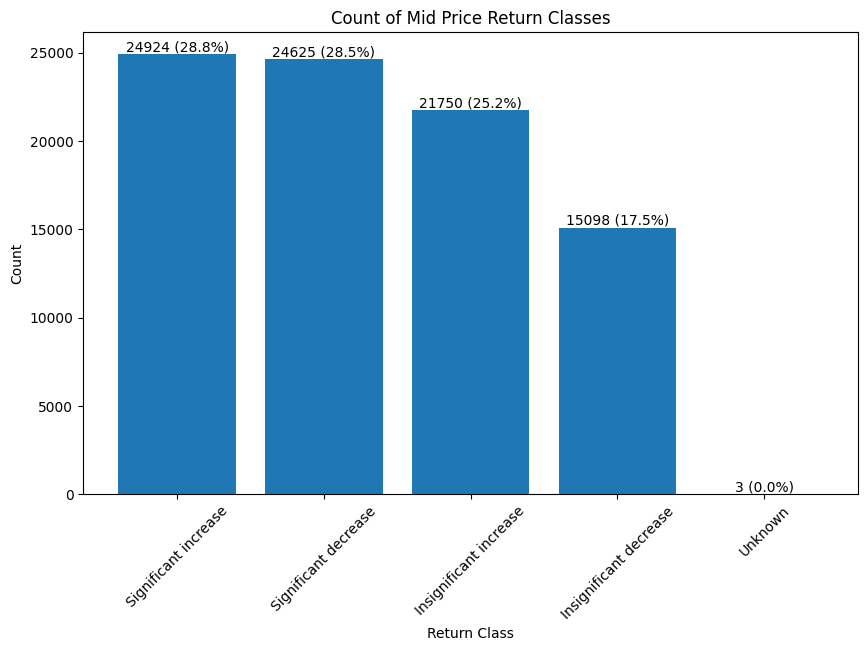

In [16]:
# 분류된 데이터로 그래프 작업 진행
temp_counts = df['mid_price_return_class'].value_counts()

# 전체 개수 대비 비율 계산
total_count = temp_counts.sum()
percentages = (temp_counts / total_count) * 100

# 그래프 생성 및 개수, 퍼센티지 표시
plt.figure(figsize=(10, 6))
bars = plt.bar(temp_counts.index, temp_counts.values)

# 그래프 레이블 설정
plt.xlabel('Return Class')
plt.ylabel('Count')
plt.title('Count of Mid Price Return Classes')
plt.xticks(rotation=45)

# 각 막대 위에 개수 및 비율 표시
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)} ({percentage:.1f}%)',
             ha='center', va='bottom')

plt.show()

In [17]:
# # insignificant한 데이터 추출
# df_with_insignificant = df.copy()

# # significant 데이터만 추출
# df = df[(df['mid_price_return_class'] == 'Significant increase') |
#         (df['mid_price_return_class'] == 'Significant decrease')]
# print(df.shape)

In [18]:
# 특정 변수(1_min_return, 5_min_return)를 제외하고 데이터프레임에서 제거
df = df.drop(['1_min_return', '5_min_return'], axis=1)

# 수치형 데이터만 추출하여 NaN과 무한대 값 확인
numeric_df = df.select_dtypes(include=[np.number])

# NaN 값이 있는지 확인
print("NaN counts per column:")
print(df.isna().sum().any())

# 무한대 값이 있는지 확인
print("Infinite values counts per column:")
print(np.isinf(numeric_df).sum().any())

# NaN 또는 무한대 값이 있다면 제거
#df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


NaN counts per column:
True
Infinite values counts per column:
False


In [19]:
# 종속변수 라벨을 2개의 클래스(0, 1)로 변환
label_mapping = {'Significant increase': 0, 'Significant decrease': 1,
                 'Insignificant increase': 2, 'Insignificant decrease': 3}

# 종속변수 설정
df['target_column'] = df['mid_price_return_class'].map(label_mapping)

# # 1. 먼저 학습(train)과 나머지(valid + test) 데이터를 나눕니다.
# train_data, temp_data = train_test_split(df, test_size=0.4, shuffle = False)

# # 2. 그 다음, 나머지 데이터(temp_data)를 검증(valid)과 테스트(test)로 나눕니다.
# valid_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle = False)

# # 결과 확인
# print(f"Train set size: {train_data.shape}")
# print(f"Validation set size: {valid_data.shape}")
# print(f"Test set size: {test_data.shape}")


In [20]:
df['target_column'].value_counts()

,count
target_column,
0,24924
1,24625
2,21724
3,15098


In [21]:
df['target_column_2'] = df['target_column'].shift(30)
#df.iloc[:50][['target_column', 'target_column_2']]

In [22]:
df['target_column'] = df['target_column_2']
df.drop(['target_column_2'], axis=1, inplace=True)
df.dropna(inplace=True)

In [23]:
# 시계열 데이터 분할 (예: 60% Train, 20% Validation, 20% Test)
train_size = int(len(df) * 0.6)
valid_size = int(len(df) * 0.2)
test_size = len(df) - train_size - valid_size

train_data = df[:train_size]
valid_data = df[train_size:train_size + valid_size]
test_data = df[train_size + valid_size:]

# 결과 확인
print(f"Train set size: {train_data.shape}")
print(f"Validation set size: {valid_data.shape}")
print(f"Test set size: {test_data.shape}")

Train set size: (51804, 88)
Validation set size: (17268, 88)
Test set size: (17269, 88)


In [24]:

# 제외할 피처들
drop_cols = ['false.2', '1_min_return_atbest', '5_min_return_atbest', 'target_column', 'mid_price', 'mid_price_diff', 'mid_price_return', 'mid_price_return_class']

# 1. StandardScaler를 학습 데이터에 대해 학습 (fit)
scaler = StandardScaler()
train_features = train_data.drop(drop_cols, axis=1).values  # 종속변수를 제외한 피처만 선택
train_features_scaled = scaler.fit_transform(train_features)

# 2. 검증 및 테스트 세트에 동일한 스케일링 적용 (transform)
valid_features = valid_data.drop(drop_cols, axis=1).values
valid_features_scaled = scaler.transform(valid_features)

test_features = test_data.drop(drop_cols, axis=1).values
test_features_scaled = scaler.transform(test_features)

# 종속변수 라벨을 4개의 클래스(0, 1)로 변환
# label_mapping = {'Significant increase': 1, 'Significant decrease': 0}
# labels = df['mid_price_return_class'].map(label_mapping)

# 3. 종속변수(라벨)도 추출
train_labels = train_data['target_column'].values
valid_labels = valid_data['target_column'].values
test_labels = test_data['target_column'].values

# 4. 텐서로 변환
train_features_tensor = torch.tensor(train_features_scaled, dtype=torch.float32)
valid_features_tensor = torch.tensor(valid_features_scaled, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features_scaled, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)  # 분류 문제이므로 long 타입
valid_labels_tensor = torch.tensor(valid_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

def augment_case0(features, labels, target_class=0, noise_scale=0.01):
    mask = labels == target_class
    augmented_features = features[mask] + torch.randn_like(features[mask]) * noise_scale
    augmented_labels = labels[mask]
    return torch.cat([features, augmented_features]), torch.cat([labels, augmented_labels])

train_features_tensor, train_labels_tensor = augment_case0(train_features_tensor, train_labels_tensor)

# 5. 결과 확인
print(f"Train features shape: {train_features_tensor.shape}")
print(f"Valid features shape: {valid_features_tensor.shape}")
print(f"Test features shape: {test_features_tensor.shape}")


Train features shape: torch.Size([66431, 80])
Valid features shape: torch.Size([17268, 80])
Test features shape: torch.Size([17269, 80])


In [25]:

# 1. TensorDataset을 사용해 특징 텐서와 라벨 텐서를 결합
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_features_tensor, valid_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

# 2. DataLoader로 데이터셋을 배치 단위로 로드
batch_size = 64  # 배치 사이즈를 설정 (필요에 따라 조정 가능)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)  # 검증과 테스트는 shuffle=False
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. DataLoader 확인
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Number of training batches: 1037
Number of validation batches: 269
Number of test batches: 270


### Transformer 모델

<ipython-input-26-7ec2e825ddb4>:133: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-26-7ec2e825ddb4>:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [1/100], Train Loss: 1.2620, Valid Loss: 3.6050
Epoch [2/100], Train Loss: 1.1027, Valid Loss: 3.0349
Epoch [3/100], Train Loss: 1.0553, Valid Loss: 2.6645
Epoch [4/100], Train Loss: 1.0452, Valid Loss: 2.4216
Epoch [5/100], Train Loss: 1.0569, Valid Loss: 2.0620
Epoch [6/100], Train Loss: 1.0635, Valid Loss: 1.6683
Epoch [7/100], Train Loss: 1.0740, Valid Loss: 1.3400
Epoch [8/100], Train Loss: 1.0772, Valid Loss: 1.1913
Epoch [9/100], Train Loss: 1.0661, Valid Loss: 1.1504
Epoch [10/100], Train Loss: 1.0468, Valid Loss: 1.1442
Epoch [11/100], Train Loss: 1.0385, Valid Loss: 1.1430
Epoch [12/100], Train Loss: 1.0461, Valid Loss: 1.1409
Epoch [13/100], Train Loss: 1.0572, Valid Loss: 1.1478
Epoch [14/100], Train Loss: 1.0435, Valid Loss: 1.1998
Epoch [15/100], Train Loss: 1.0196, Valid Loss: 1.3355
Epoch [16/100], Train Loss: 1.0018, Valid Loss: 1.5575
Early stopping triggered.


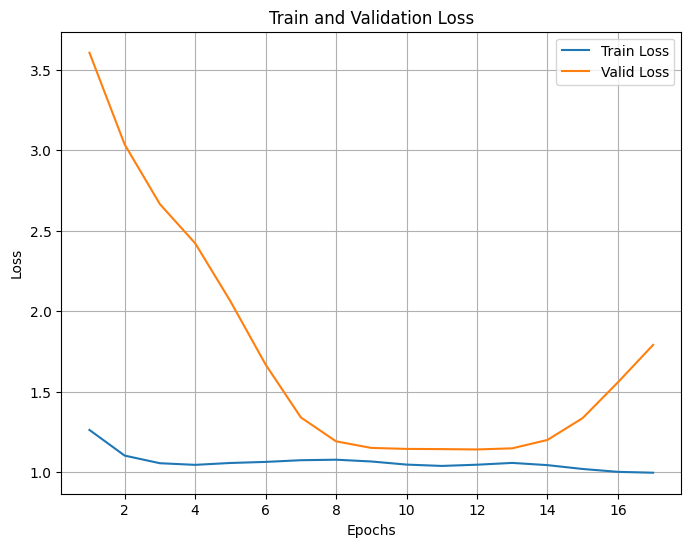

In [26]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Hyperparameters
hyperparams = {
    "input_dim": 80,               # Input feature size
    "num_classes": 4,              # Number of output classes
    "num_heads": 2,                # Number of attention heads
    "d_model": 64,                 # Dimension of transformer embeddings
    "dff": 128,                    # Dimension of feed-forward network
    "dropout_rate": 0.2,           # Dropout rate
    "batch_size": 32,              # Batch size for training
    "epochs": 100,                  # Number of training epochs
    "learning_rate": 1e-4,         # Initial learning rate
    "weight_decay": 1e-5,          # Weight decay for regularization
    "gradient_clipping": 1.0,      # Max norm for gradient clipping
    "lr_scheduler_patience": 3,    # Patience for learning rate reduction
    "model_save_path": "./model_structure", # Directory to save the model
}

# Create model save directory
os.makedirs(hyperparams["model_save_path"], exist_ok=True)

# Transformer Model Definition
class TransformerClassifierNonSequence(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads, d_model, dff, dropout_rate):
        super(TransformerClassifierNonSequence, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.self_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.BatchNorm1d(dff),  # BatchNorm 추가
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.embedding(x)
        attention_output, _ = self.self_attention(x, x, x)
        x = self.norm1(x + attention_output)
        x = x.squeeze(1)  # Remove sequence dimension

        # Feedforward network with residual connection
        ff_input = x
        x = self.feed_forward(x)
        x = self.norm2(ff_input + x)

        x = self.dropout(x)
        return self.fc(x)

# Weight Initialization
def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)

# Dataset Loaders
# Assume `train_loader` and `valid_loader` are already defined and scaled.

# Model, Loss, Optimizer, Scheduler
model = TransformerClassifierNonSequence(
    input_dim=hyperparams["input_dim"],
    num_classes=hyperparams["num_classes"],
    num_heads=hyperparams["num_heads"],
    d_model=hyperparams["d_model"],
    dff=hyperparams["dff"],
    dropout_rate=hyperparams["dropout_rate"],
)
initialize_weights(model)

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
#         pt = torch.exp(-ce_loss)  # Probabilities
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
#         return focal_loss.mean()

# # Focal Loss 사용
# criterion = FocalLoss(alpha=1, gamma=2)

class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)  # Probabilities
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        # Apply class weights if provided
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        return focal_loss.mean()

# Class weights (case0: 가장 중요, 나머지는 상대적으로 낮은 가중치)
class_weights = torch.tensor([5.0, 1.0, 1.0, 1.0], dtype=torch.float32)  # Customize as needed
criterion = WeightedFocalLoss(alpha=class_weights, gamma=2)

optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])

# Learning rate warm-up scheduler
def lr_lambda(epoch):
    warmup_epochs = 5
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 0.95 ** (epoch - warmup_epochs)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Mixed Precision Training
scaler = GradScaler()

# Training and Validation Loop
best_valid_loss = float('inf')
train_losses, valid_losses = [], []
early_stopping_patience = 5
trigger = 0

for epoch in range(hyperparams["epochs"]):
    # Training Phase
    model.train()
    epoch_train_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(torch.float32), targets
        optimizer.zero_grad()

        # Mixed Precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=hyperparams["gradient_clipping"])
        scaler.step(optimizer)
        scaler.update()

        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()
    epoch_valid_loss = 0.0

    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(torch.float32), targets
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_valid_loss += loss.item()

    valid_loss = epoch_valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    # Scheduler step
    scheduler.step()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(hyperparams["model_save_path"], 'best_model.pth'))
        trigger = 0
    else:
        trigger += 1

    # Early stopping
    if trigger >= early_stopping_patience:
        print("Early stopping triggered.")
        break

    # Print epoch results
    print(f"Epoch [{epoch+1}/{hyperparams['epochs']}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# Visualization of Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid()
plt.show()



<ipython-input-27-e5c37dadf251>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(hyperparams["model_save_path"], 'best_model.pt

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.33      1.00      0.49      5658
     Class 1       0.00      0.00      0.00      5889
     Class 2       0.00      0.00      0.00      3090
     Class 3       0.00      0.00      0.00      2632

    accuracy                           0.33     17269
   macro avg       0.08      0.25      0.12     17269
weighted avg       0.11      0.33      0.16     17269



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


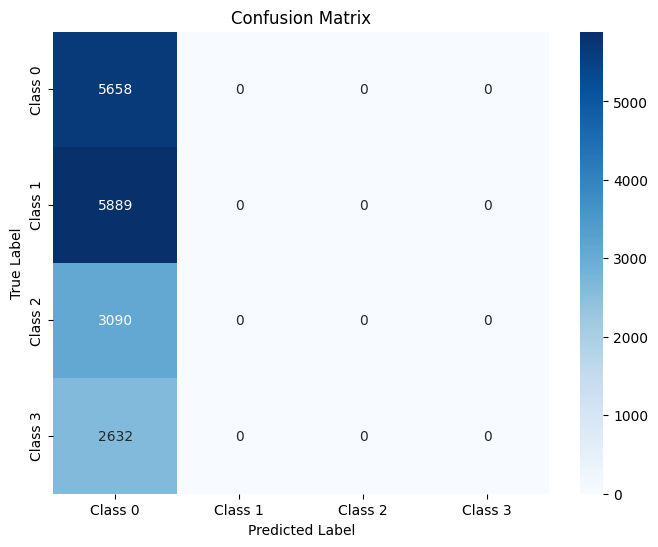

In [27]:
# Classification Report and Confusion Matrix for Test Data
model.load_state_dict(torch.load(os.path.join(hyperparams["model_save_path"], 'best_model.pth')))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(torch.float32)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Metrics
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


<ipython-input-28-4fc2672d2c89>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))  # 저장된 베스트 모델 로드


Classification Report:
                        precision    recall  f1-score   support

  Significant increase       0.33      1.00      0.49      5658
  Significant decrease       0.00      0.00      0.00      5889
Insignificant increase       0.00      0.00      0.00      3090
Insignificant decrease       0.00      0.00      0.00      2632

              accuracy                           0.33     17269
             macro avg       0.08      0.25      0.12     17269
          weighted avg       0.11      0.33      0.16     17269

Accuracy: 0.3276


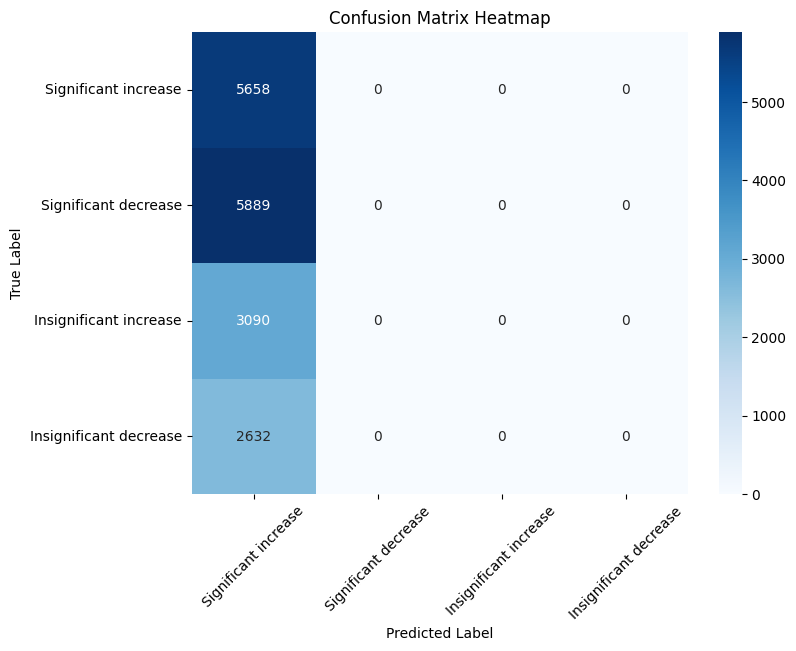

In [28]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# 베스트 모델 로드 및 테스트 데이터에서 예측 수행
best_model_path = os.path.join(hyperparams["model_save_path"], 'best_model.pth')

# 모델 초기화 및 저장된 베스트 모델 로드
model = TransformerClassifierNonSequence(
    input_dim=hyperparams["input_dim"],
    num_classes=hyperparams["num_classes"],
    num_heads=hyperparams["num_heads"],
    d_model=hyperparams["d_model"],
    dff=hyperparams["dff"],
    dropout_rate=hyperparams["dropout_rate"],
)
model.load_state_dict(torch.load(best_model_path))  # 저장된 베스트 모델 로드
model.eval()  # 평가 모드로 전환

# 테스트 데이터에서 예측 수행
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:  # test_loader에서 데이터 로드
        features = features.to(torch.float32)  # Ensure input data type
        outputs = model(features)
        _, preds = torch.max(outputs, 1)  # 예측 클래스 선택

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. 분류 성능 보고서 출력 (정확도, 정밀도, 재현율, F1 스코어)
target_names = [
    'Significant increase',   # Class 0
    'Significant decrease',   # Class 1
    'Insignificant increase', # Class 2
    'Insignificant decrease'  # Class 3
]

# Classification report 출력
report = classification_report(all_labels, all_preds, target_names=target_names, zero_division=0)
print("Classification Report:")
print(report)

# Accuracy 계산 및 출력
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# 2. 혼동 행렬 계산 및 시각화
cm = confusion_matrix(all_labels, all_preds)

# 혼동 행렬 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)  # x축 라벨 45도 회전
plt.show()


### 실제 데이터에 적용
- insignificant increase, decrease도 적용

- Precision (정밀도):

정밀도는 모델이 해당 클래스로 예측한 값 중 실제로 맞은 비율입니다.
예를 들어, "Significant increase" 클래스에 대해 모델이 98%의 정밀도를 보였다는 것은, 모델이 이 클래스로 예측한 값 중 98%가 실제로 맞았다는 의미입니다.
하지만 "Significant decrease" 클래스는 데이터에 등장하지 않아서 정밀도가 0.00으로 표시되었습니다.

- Recall (재현율):

재현율은 실제로 해당 클래스에 속한 데이터 중에서 모델이 올바르게 예측한 비율입니다.
예를 들어, "Insignificant increase" 클래스에 대한 재현율이 0.92라는 것은, 실제로 "Insignificant increase"에 속한 데이터 중 92%를 모델이 정확히 맞췄다는 의미입니다.
"Significant increase" 클래스의 재현율이 0.01이라는 것은, 이 클래스에 속한 실제 데이터 중 1%만 모델이 맞췄다는 의미입니다.

- F1-score:

F1 스코어는 정밀도와 재현율의 조화평균으로, 두 지표를 종합적으로 평가하는 지표입니다. 정밀도와 재현율 사이의 균형을 중요시할 때 유용합니다.
예를 들어, "Insignificant increase" 클래스의 F1 스코어가 0.84라는 것은, 정밀도와 재현율이 적절히 균형을 이뤘음을 의미합니다.

- Support:

Support는 각 클래스에 실제로 속한 데이터의 개수입니다.
예를 들어, "Insignificant increase" 클래스는 241,234개의 데이터 포인트를 가지고 있다는 것을 의미합니다.

- Micro avg (마이크로 평균):

마이크로 평균은 전체 데이터에서의 정밀도, 재현율, F1 스코어를 계산합니다. 이는 각 클래스의 데이터 개수를 고려하지 않고, 전체 데이터를 한 번에 평가하는 방식입니다.
마이크로 평균 77%는 모든 클래스의 데이터를 합쳐서 모델이 77%의 정확도를 보였음을 의미합니다.

- Macro avg (매크로 평균):

매크로 평균은 각 클래스의 정밀도, 재현율, F1 스코어의 평균을 단순히 계산한 것입니다. 이는 클래스별 데이터 비율을 고려하지 않기 때문에, 클래스 간 불균형이 있는 경우 잘못된 평가가 나올 수 있습니다.
예를 들어, "Significant decrease" 클래스처럼 데이터가 없는 클래스는 성능이 0으로 평가되며, 이러한 클래스들도 평균에 포함되기 때문에 성능이 낮아집니다.

- Weighted avg (가중 평균):

가중 평균은 각 클래스의 정밀도, 재현율, F1 스코어를 해당 클래스의 데이터 개수에 비례하여 평균을 계산한 것입니다. 즉, 클래스의 데이터가 많을수록 해당 클래스의 성능이 평균에 더 큰 영향을 줍니다.
Weighted 평균 77%는 실제 데이터 비율에 따라 가중치를 부여하여 계산한 성능입니다. 이 값은 전체적으로 모델이 77%의 정확도를 가지고 있음을 보여줍니다.